In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/travel-behavior-insights/sample_submission.csv
/kaggle/input/travel-behavior-insights/train.csv
/kaggle/input/travel-behavior-insights/test.csv


In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import warnings
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers
from sklearn.utils.class_weight import compute_class_weight
warnings.filterwarnings('ignore')
train_df = pd.read_csv("/kaggle/input/travel-behavior-insights/train.csv")
test_df = pd.read_csv("/kaggle/input/travel-behavior-insights/test.csv")
train_df.info()
test_df.info()

2025-11-27 13:42:05.598218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764250925.894215      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764250925.967911      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12654 entries, 0 to 12653
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   trip_id                      12654 non-null  object 
 1   country                      12424 non-null  object 
 2   age_group                    12646 non-null  object 
 3   travel_companions            11917 non-null  object 
 4   num_females                  12652 non-null  float64
 5   num_males                    12650 non-null  float64
 6   main_activity                12526 non-null  object 
 7   visit_purpose                12654 non-null  object 
 8   is_first_visit               12555 non-null  object 
 9   mainland_stay_nights         12654 non-null  int64  
 10  island_stay_nights           12654 non-null  int64  
 11  tour_type                    12654 non-null  object 
 12  intl_transport_included      12507 non-null  object 
 13  info_source     

In [3]:
'''It can be seen that the target variable spend_category has some rows where its value is null. It is best to drop these 
rows (as there are not many compared to the overall dataset size) rather than imputing values and introducing bias'''

train_df.dropna(subset=['spend_category'], inplace=True)

#plotting missing percentages after dropping the rows with missing spend_category
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12620 entries, 0 to 12653
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   trip_id                      12620 non-null  object 
 1   country                      12393 non-null  object 
 2   age_group                    12612 non-null  object 
 3   travel_companions            11887 non-null  object 
 4   num_females                  12618 non-null  float64
 5   num_males                    12616 non-null  float64
 6   main_activity                12492 non-null  object 
 7   visit_purpose                12620 non-null  object 
 8   is_first_visit               12522 non-null  object 
 9   mainland_stay_nights         12620 non-null  int64  
 10  island_stay_nights           12620 non-null  int64  
 11  tour_type                    12620 non-null  object 
 12  intl_transport_included      12474 non-null  object 
 13  info_source          

In [4]:
#For the numerical cols num_males and num_females which have very low missing percentages, we impute the missing values with the median
train_df['has_special_requirements_missing'] = train_df['has_special_requirements'].isnull().astype(int)
test_df['has_special_requirements_missing'] = test_df['has_special_requirements'].isnull().astype(int)
train_df['arrival_weather_missing'] = train_df['arrival_weather'].isnull().astype(int)
test_df['arrival_weather_missing'] = test_df['arrival_weather'].isnull().astype(int)

missing_numerical_cols = ['num_females', 'num_males']
for col in missing_numerical_cols:
    median_val = train_df[col].median()
    train_df[col] = train_df[col].fillna(median_val)
    test_df[col] = test_df[col].fillna(median_val)

#For categorical columns with low missing percentages, we impute the missing values with the mode
missing_categorical_cols = ['country','age_group','main_activity','travel_companions', 'is_first_visit', 'intl_transport_included', 'accomodation_included', 'food_included', 'insurance_included', 'days_booked_before_trip', 'total_trip_days']
for col in missing_categorical_cols:
    mode_val = train_df[col].mode()[0]
    train_df[col] = train_df[col].fillna(mode_val)
    test_df[col] = test_df[col].fillna(mode_val)

#Fill with "none" - missingness indicator already created
train_df['has_special_requirements'] = train_df['has_special_requirements'].fillna("none")
test_df['has_special_requirements'] = test_df['has_special_requirements'].fillna("none")

#For arrival_weather we fill the missing values with "other"
train_df['arrival_weather'] = train_df['arrival_weather'].fillna("none")
test_df['arrival_weather'] = test_df['arrival_weather'].fillna("none")

#Feature Engineering
# Total travelers
train_df['total_travelers'] = train_df['num_females'] + train_df['num_males']
test_df['total_travelers'] = test_df['num_females'] + test_df['num_males']

# Gender ratio
train_df['female_ratio'] = train_df['num_females'] / (train_df['total_travelers'] + 1e-6)
test_df['female_ratio'] = test_df['num_females'] / (test_df['total_travelers'] + 1e-6)

# Stay nights features
train_df['total_stay_nights'] = train_df['mainland_stay_nights'] + train_df['island_stay_nights']
test_df['total_stay_nights'] = test_df['mainland_stay_nights'] + test_df['island_stay_nights']

train_df['island_ratio'] = train_df['island_stay_nights'] / (train_df['total_stay_nights'] + 1e-6)
test_df['island_ratio'] = test_df['island_stay_nights'] / (test_df['total_stay_nights'] + 1e-6)

# Mainland preference (binary)
train_df['prefers_mainland'] = (train_df['mainland_stay_nights'] > train_df['island_stay_nights']).astype(int)
test_df['prefers_mainland'] = (test_df['mainland_stay_nights'] > test_df['island_stay_nights']).astype(int)


included_cols = ['intl_transport_included', 'accomodation_included', 'food_included',
                 'domestic_transport_included', 'sightseeing_included', 
                 'guide_included', 'insurance_included']

# Fill missing with mode for each
for col in included_cols:
    if train_df[col].isnull().sum() > 0:
        mode_val = train_df[col].mode()[0]
        train_df[col] = train_df[col].fillna(mode_val)
        test_df[col] = test_df[col].fillna(mode_val)

# Count services
train_df['num_services_included'] = train_df[included_cols].apply(
    lambda x: (x == 'Yes').sum(), axis=1
)
test_df['num_services_included'] = test_df[included_cols].apply(
    lambda x: (x == 'Yes').sum(), axis=1
)

# Service ratio
train_df['service_ratio'] = train_df['num_services_included'] / len(included_cols)
test_df['service_ratio'] = test_df['num_services_included'] / len(included_cols)

# Is comprehensive package (most services included)
train_df['is_comprehensive_package'] = (train_df['num_services_included'] >= 5).astype(int)
test_df['is_comprehensive_package'] = (test_df['num_services_included'] >= 5).astype(int)

train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12620 entries, 0 to 12653
Data columns (total 35 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   trip_id                           12620 non-null  object 
 1   country                           12620 non-null  object 
 2   age_group                         12620 non-null  object 
 3   travel_companions                 12620 non-null  object 
 4   num_females                       12620 non-null  float64
 5   num_males                         12620 non-null  float64
 6   main_activity                     12620 non-null  object 
 7   visit_purpose                     12620 non-null  object 
 8   is_first_visit                    12620 non-null  object 
 9   mainland_stay_nights              12620 non-null  int64  
 10  island_stay_nights                12620 non-null  int64  
 11  tour_type                         12620 non-null  object 
 12  intl_tran

In [5]:
pip install pycountry_convert

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 53.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
from sklearn.model_selection import KFold
from pycountry_convert import country_name_to_country_alpha2, country_alpha2_to_continent_code


#Encoding

#country encoding
from pycountry_convert import country_name_to_country_alpha2, country_alpha2_to_continent_code

def get_continent(country_name):
    try:
        alpha2 = country_name_to_country_alpha2(country_name)
        continent = country_alpha2_to_continent_code(alpha2)
        return continent
    except:
        return 'Unknown'

# Fill missing countries before encoding
train_df['country'] = train_df['country'].fillna('Unknown')
test_df['country'] = test_df['country'].fillna('Unknown')

# A. Continent
train_df['continent'] = train_df['country'].apply(get_continent)
test_df['continent'] = test_df['country'].apply(get_continent)

# B. Country frequency
country_freq = train_df['country'].value_counts()
train_df['country_freq'] = train_df['country'].map(country_freq).fillna(0)
test_df['country_freq'] = test_df['country'].map(country_freq).fillna(0)

# C. Top countries
top_countries = train_df['country'].value_counts().head(15).index.tolist()
train_df['is_top_country'] = train_df['country'].isin(top_countries).astype(int)
test_df['is_top_country'] = test_df['country'].isin(top_countries).astype(int)

# D. Target encoding for country
def target_encode_country(train_df, test_df, col='country', target='spend_category', n_splits=5):
    train_df[f'{col}_target_enc'] = 0.0
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for train_idx, val_idx in kf.split(train_df, train_df[target]):
        means = train_df.iloc[train_idx].groupby(col)[target].mean()
        train_df.loc[train_df.index[val_idx], f'{col}_target_enc'] = \
            train_df.iloc[val_idx][col].map(means)
    
    global_mean = train_df[target].mean()
    train_df[f'{col}_target_enc'] = train_df[f'{col}_target_enc'].fillna(global_mean)
    
    means = train_df.groupby(col)[target].mean()
    test_df[f'{col}_target_enc'] = test_df[col].map(means).fillna(global_mean)
    
    return train_df, test_df

train_df, test_df = target_encode_country(train_df, test_df)
train_df = train_df.drop(columns=['country'])
test_df = test_df.drop(columns=['country'])

#age_group encoding
age_group_order = ['<18', '18-24', '25-44', '45-64', '65+']
age_group_map = {category: i for i, category in enumerate(age_group_order)}

# Fill missing with mode first
train_mode = train_df['age_group'].mode()[0]
train_df['age_group'] = train_df['age_group'].fillna(train_mode)
test_df['age_group'] = test_df['age_group'].fillna(train_mode)

train_df['age_group_encoded'] = train_df['age_group'].map(age_group_map)
test_df['age_group_encoded'] = test_df['age_group'].map(age_group_map)
train_df.drop('age_group', axis=1, inplace=True)
test_df.drop('age_group', axis=1, inplace=True)

#We drop the trip_id column as it is just an indentifier and does not have any correlation with the target variable

#Encoding days_booked_before trip
# These are ranges: "0-7", "8-14", "15-30", "31-60", "61-90", "90+"
booking_order = ['0-7', '8-14', '15-30', '31-60', '61-90', '90+']
booking_map = {category: i for i, category in enumerate(booking_order)}

# Fill missing with mode
train_mode = train_df['days_booked_before_trip'].mode()[0]
train_df['days_booked_before_trip'] = train_df['days_booked_before_trip'].fillna(train_mode)
test_df['days_booked_before_trip'] = test_df['days_booked_before_trip'].fillna(train_mode)

train_df['days_booked_encoded'] = train_df['days_booked_before_trip'].map(booking_map)
test_df['days_booked_encoded'] = test_df['days_booked_before_trip'].map(booking_map)

# Handle any unmapped values
train_df['days_booked_encoded'] = train_df['days_booked_encoded'].fillna(train_df['days_booked_encoded'].median())
test_df['days_booked_encoded'] = test_df['days_booked_encoded'].fillna(train_df['days_booked_encoded'].median())

train_df.drop('days_booked_before_trip', axis=1, inplace=True)
test_df.drop('days_booked_before_trip', axis=1, inplace=True)

#Encoding total_trip_days
# These are ranges: "1-3", "4-6", "7-14", "30+"
trip_days_order = ['1-3', '4-6', '7-14', '30+']
trip_days_map = {category: i for i, category in enumerate(trip_days_order)}

# Fill missing with mode
train_mode = train_df['total_trip_days'].mode()[0]
train_df['total_trip_days'] = train_df['total_trip_days'].fillna(train_mode)
test_df['total_trip_days'] = test_df['total_trip_days'].fillna(train_mode)

train_df['total_trip_days_encoded'] = train_df['total_trip_days'].map(trip_days_map)
test_df['total_trip_days_encoded'] = test_df['total_trip_days'].map(trip_days_map)

# Handle any unmapped values
train_df['total_trip_days_encoded'] = train_df['total_trip_days_encoded'].fillna(train_df['total_trip_days_encoded'].median())
test_df['total_trip_days_encoded'] = test_df['total_trip_days_encoded'].fillna(train_df['total_trip_days_encoded'].median())

train_df.drop('total_trip_days', axis=1, inplace=True)
test_df.drop('total_trip_days', axis=1, inplace=True)

train_df = train_df.drop(columns=['trip_id'])
test_trip_ids = test_df['trip_id'].copy()
test_df = test_df.drop(columns=['trip_id'])

# Get categorical columns (only object dtype)
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
print(f"\nCategorical columns to one-hot encode: {categorical_cols}")

# Combine and encode
train_num_rows = train_df.shape[0]
combined_df = pd.concat([train_df, test_df], ignore_index=True)

combined_encoded_df = pd.get_dummies(combined_df, 
                                     columns=categorical_cols, 
                                     drop_first=True)

# Split back
train_df_encoded = combined_encoded_df.iloc[:train_num_rows].copy()
test_df_encoded = combined_encoded_df.iloc[train_num_rows:].copy()

print(f"Shape of encoded training data: {train_df_encoded.shape}")
print(f"Shape of encoded testing data: {test_df_encoded.shape}")


Categorical columns to one-hot encode: ['travel_companions', 'main_activity', 'visit_purpose', 'is_first_visit', 'tour_type', 'intl_transport_included', 'info_source', 'accomodation_included', 'food_included', 'domestic_transport_included', 'sightseeing_included', 'guide_included', 'insurance_included', 'arrival_weather', 'has_special_requirements', 'continent']
Shape of encoded training data: (12620, 67)
Shape of encoded testing data: (5852, 67)


In [7]:
X = train_df_encoded.drop('spend_category', axis=1)
y = train_df_encoded['spend_category']
X_test_final = test_df_encoded.drop('spend_category', axis=1, errors='ignore')

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Class distribution in y_train:\n{y_train.value_counts()}")


Shape of X_train: (10096, 66)
Shape of X_val: (2524, 66)
Class distribution in y_train:
spend_category
0.0    4996
1.0    3929
2.0    1171
Name: count, dtype: int64



Number of classes: 3

Class weights: {0: 0.6736055511075527, 1: 0.8565368626452872, 2: 2.873896954170225}

MODEL 1: Basic Neural Network

Model Architecture:


2025-11-27 13:42:31.482116: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         8,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,011 (74.26 KB)

 Trainable params: 19,011 (74.26 KB)

 Non-trainable params: 0 (0.00 B)


Training basic neural network...
Epoch 1/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6298 - loss: 0.8445 - val_accuracy: 0.7080 - val_loss: 0.6677 - learning_rate: 0.0010
Epoch 2/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7050 - loss: 0.7140 - val_accuracy: 0.7242 - val_loss: 0.6485 - learning_rate: 0.0010
Epoch 3/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7175 - loss: 0.6937 - val_accuracy: 0.6854 - val_loss: 0.6902 - learning_rate: 0.0010
Epoch 4/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7069 - loss: 0.6899 - val_accuracy: 0.7357 - val_loss: 0.6324 - learning_rate: 0.0010
Epoch 5/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7097 - loss: 0.6751 - val_accuracy: 0.7349 - val_loss: 0.6262 - learning_rate: 0.0010
Epoch 6/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7068 - loss: 0.6893 - val_accuracy: 0.7088 - val_loss: 0.6480 - learning_rate: 0.0010
Epoch 7/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/

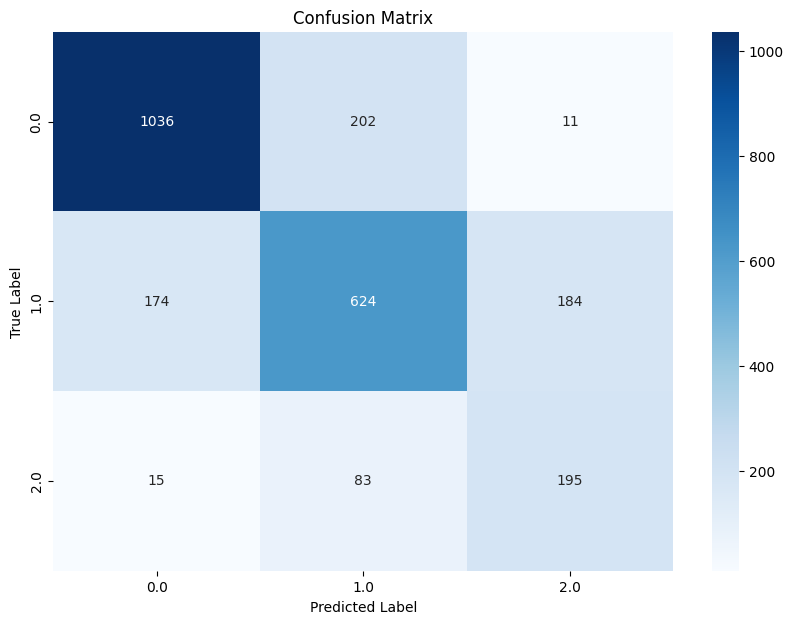

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
numerical_cols = ['num_males', 'num_females', 'mainland_stay_nights', 
                  'island_stay_nights', 'total_travelers', 'female_ratio',
                  'total_stay_nights', 'island_ratio', 'country_freq', 
                  'country_target_enc', 'age_group_encoded', 'days_booked_encoded',
                  'total_trip_days_encoded', 'num_services_included', 'service_ratio']

scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test_final[numerical_cols] = scaler.transform(X_test_final[numerical_cols])

y_train_int = y_train.astype(int).values
y_val_int = y_val.astype(int).values

n_classes = len(np.unique(y_train_int))
print(f"\nNumber of classes: {n_classes}")

# ============================================================================
# Calculate Class Weights for Imbalanced Data
# ============================================================================
class_weights_array = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)
class_weights = dict(enumerate(class_weights_array))
print(f"\nClass weights: {class_weights}")

print("\n" + "="*80)
print("MODEL 1: Basic Neural Network")
print("="*80)

def create_basic_nn(input_dim, n_classes):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create model
basic_nn = create_basic_nn(X_train.shape[1], n_classes)
print("\nModel Architecture:")
basic_nn.summary()

# Callbacks
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Train
print("\nTraining basic neural network...")
history_basic = basic_nn.fit(
    X_train, y_train_int,
    validation_data=(X_val, y_val_int),
    epochs=100,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluate
y_pred_basic = basic_nn.predict(X_val)
y_pred_basic_classes = np.argmax(y_pred_basic, axis=1)

print("\n" + "="*80)
print("BASIC NN RESULTS:")
print("="*80)
print(classification_report(y_val_int, y_pred_basic_classes))
print(f"\nWeighted F1: {f1_score(y_val_int, y_pred_basic_classes, average='weighted'):.4f}")
print(f"Macro F1: {f1_score(y_val_int, y_pred_basic_classes, average='macro'):.4f}")
print(f"\nConfusion Matrix:\n{confusion_matrix(y_val_int, y_pred_basic_classes)}")

plt.figure(figsize=(10, 7))
# Note: You might need to adjust the `xticklabels` and `yticklabels`
# to match the actual category names if they are not 0, 1, 2, etc.
sns.heatmap(confusion_matrix(y_val, y_pred_basic_classes), annot=True, fmt='d', cmap='Blues',
            xticklabels=['0.0', '1.0', '2.0'], yticklabels=['0.0', '1.0', '2.0'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [9]:
# 1. Use your trained model to make predictions on the processed test data.
predictions = basic_nn.predict(X_test_final)
final_predictions = np.argmax(predictions, axis=1)


# 2. Create a new DataFrame for the submission file.
#    The dictionary keys will become the column names.
submission_df = pd.DataFrame({
    'trip_id': test_trip_ids,
    'spend_category': final_predictions
})

# 3. Save the DataFrame to a CSV file.
#    index=False is essential to prevent writing an unwanted index column.
submission_df.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' has been created successfully.")
print("\nFirst 5 rows of the submission file:")
print(submission_df.head())

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Submission file 'submission.csv' has been created successfully.

First 5 rows of the submission file:
           trip_id  spend_category
0  tour_id8gzpck76               2
1  tour_idow1zxkou               0
2  tour_idue7esfqz               0
3  tour_idnj3mjzpb               0
4  tour_ida3us5yk2               0
